In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load the Breast Cancer Wisconsin dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

print("\nDataset shape:", X.shape)
print("\nTarget distribution:")
print(y.value_counts())
print("\n0: Malignant, 1: Benign")

Using device: cuda
GPU: NVIDIA GeForce RTX 3090

Dataset shape: (569, 30)

Target distribution:
target
1    357
0    212
Name: count, dtype: int64

0: Malignant, 1: Benign


In [2]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors and move to device
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).to(device)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
print(f"Input features: {X_train_tensor.shape[1]}")

Training set size: 455
Test set size: 114
Input features: 30


In [3]:
# Define a simple linear model (logistic regression in PyTorch)
class LinearClassifier(nn.Module):
    def __init__(self, input_dim):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Initialize model and move to device
input_dim = X_train_tensor.shape[1]
model = LinearClassifier(input_dim).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training
num_epochs = 1000
batch_size = 32

# Create data loader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Training the model...")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

print("Training completed!")

Training the model...
Epoch [100/1000], Loss: 0.0444
Epoch [100/1000], Loss: 0.0444
Epoch [200/1000], Loss: 0.0417
Epoch [200/1000], Loss: 0.0417
Epoch [300/1000], Loss: 0.0372
Epoch [300/1000], Loss: 0.0372
Epoch [400/1000], Loss: 0.0391
Epoch [400/1000], Loss: 0.0391
Epoch [500/1000], Loss: 0.0450
Epoch [500/1000], Loss: 0.0450
Epoch [600/1000], Loss: 0.0318
Epoch [600/1000], Loss: 0.0318
Epoch [700/1000], Loss: 0.0313
Epoch [700/1000], Loss: 0.0313
Epoch [800/1000], Loss: 0.0285
Epoch [800/1000], Loss: 0.0285
Epoch [900/1000], Loss: 0.0278
Epoch [900/1000], Loss: 0.0278
Epoch [1000/1000], Loss: 0.0446
Training completed!
Epoch [1000/1000], Loss: 0.0446
Training completed!


In [4]:
# Make predictions
model.eval()
with torch.no_grad():
    y_pred_train_prob = model(X_train_tensor).squeeze()
    y_pred_test_prob = model(X_test_tensor).squeeze()
    
    y_pred_train = (y_pred_train_prob > 0.5).float().cpu().numpy()
    y_pred_test = (y_pred_test_prob > 0.5).float().cpu().numpy()

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Detailed classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, target_names=['Malignant', 'Benign']))

Training Accuracy: 0.9890
Test Accuracy: 0.9737

Classification Report (Test Set):
              precision    recall  f1-score   support

   Malignant       0.98      0.95      0.96        42
      Benign       0.97      0.99      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



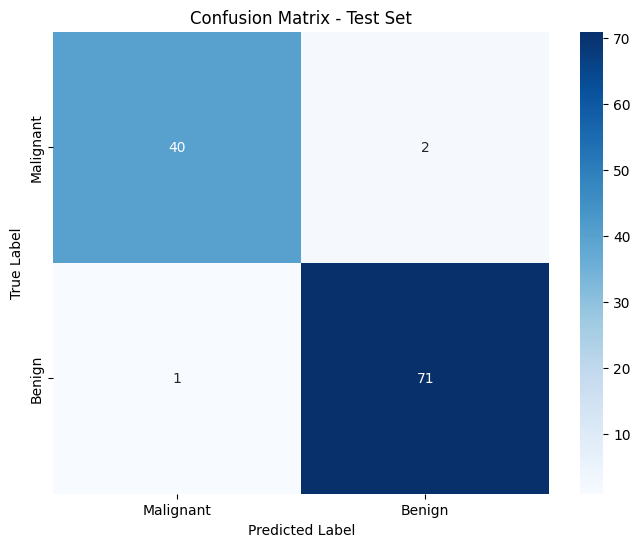

In [5]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

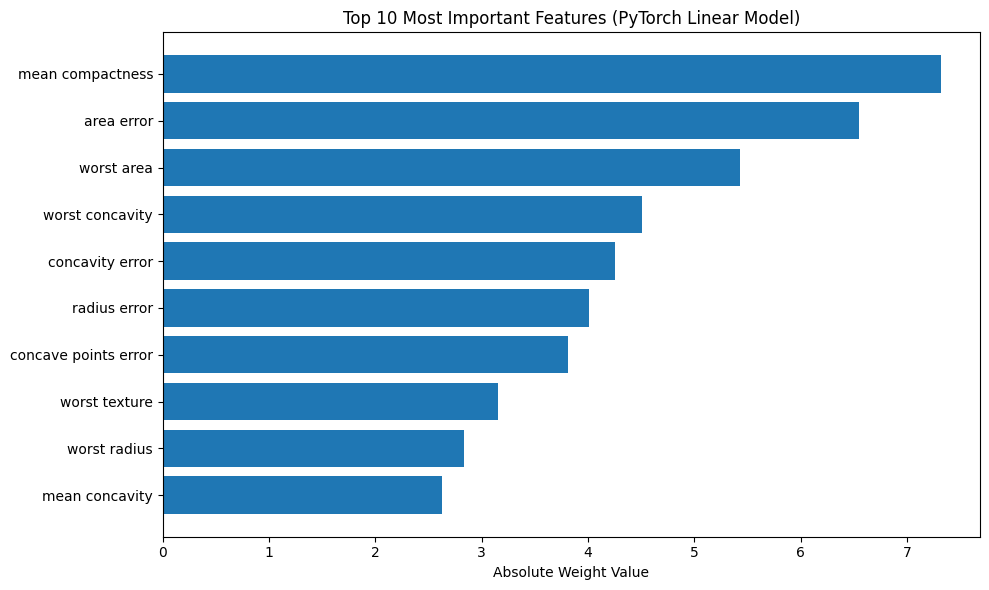


Top 10 Most Important Features:
                 feature  importance
5       mean compactness    7.319734
13            area error    6.545031
23            worst area    5.424205
26       worst concavity    4.511345
16       concavity error    4.254207
10          radius error    4.006858
17  concave points error    3.812779
21         worst texture    3.149444
20          worst radius    2.832228
6         mean concavity    2.624249


In [6]:
# Feature importance - extract weights from the linear layer
weights = model.linear.weight.detach().cpu().numpy().squeeze()
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(weights)
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xlabel('Absolute Weight Value')
plt.title('Top 10 Most Important Features (PyTorch Linear Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))